![logo](https://github.com/donatellacea/DL_tutorials/blob/main/notebooks/figures/1128-191-max.png?raw=true)

# XAI in Deep Learning-Based Image Analysis: The Attention Maps

In this tutorial...TODO: add one-liner explanation

-------

## Getting Started

### Setup Colab environment

If you installed the packages and requirements on your own machine, you can skip this section and start from the import section.
Otherwise, you can follow and execute the tutorial on your browser. In order to start working on the notebook, click on the following button, this will open this page in the Colab environment and you will be able to execute the code on your own.

<a href="https://colab.research.google.com/github/HelmholtzAI-Consultants-Munich/Zero2Hero---Introduction-to-XAI/blob/Juelich-2023/xai-model-specific/Tutorial_attention_maps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Now that you opened the notebook in Colab, follow the next step:

1. Run this cell to connect your Google Drive to Colab and install packages
2. Allow this notebook to access your Google Drive files. Click on 'Yes', and select your account.
3. "Google Drive for desktop wants to access your Google Account". Click on 'Allow'.
   
At this point, a folder has been created in your Drive and you can navigate it through the lefthand panel in Colab, you might also have received an email that informs you about the access on your Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive
!git clone --branch Juelich-2023 https://github.com/HelmholtzAI-Consultants-Munich/XAI-Tutorials.git
%cd XAI-Tutorials/xai-model-specific
# TODO: install packages not already present in Colab, e.g. %pip install lime

### Imports

Let's start with importing all required Python packages.

In [1]:
%matplotlib inline
import sys

import numpy as np
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt 

import warnings
warnings.filterwarnings("ignore")

import utils
sys.path.append('../data_and_models/')
from vit import VitGenerator

We fix the random seeds to ensure reproducible results, as we work with (pseudo) random numbers.

In [2]:
# assert reproducible random number generation
seed = 1
np.random.seed(seed)
torch.manual_seed(seed)

## Data Loading

We first load the image we want to analyse and convert it to RGB channel, 

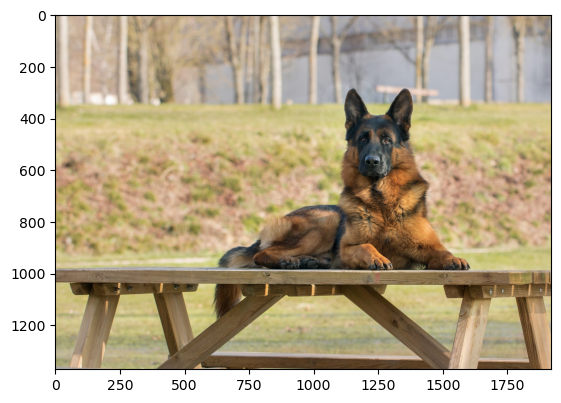

Image size:  (1371, 1920, 3)


In [3]:
# Visualizing Dog Image
# '../data_and_models/images/Iguana.jpeg'
path = '../data_and_models/images/dog.jpg'
img = utils.read_img(path)
plt.imshow(img)
plt.show()

print("Image size: ", img.shape)


We need to perform some transformations to the image (convert to PIL format, resize to lower resolution, convert to tensor dtype and normalize the pixel values) and unsqueeze the image to add a batch dimension.

Because the image size is too big. We will reduce it by a factor of 2. 
Resizing the image here can be for several reasons.
- If the image is too large, attention maps might be too detailed and harder to interpret. By reducing the size, attention patterns might become more evident, providing clearer insights into which parts of the image the model focuses on.
- Reducing the image size might ensure that patches cover meaningful parts of the image and don't introduce artifacts due to partial objects or features.
- Larger images have more pixels, and processing them can be computationally expensive. Reducing the image size can make the processing faster.

In [4]:
# define the transformations (here we are using the ImageNet transformations)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

factor_reduce = 2
img_size = tuple(np.array(img.shape[:2]) // factor_reduce)

img_pre = utils.transform_img(img, mean, std, img_size=img_size)
print('Transformed image size: ', img_pre.size())
     

Transformed image size:  torch.Size([1, 3, 685, 960])


## Model Loading
 
Let's load our model.

First, we check the available device (either cpu or gpu)

In [5]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
if device.type == "cuda":
    torch.cuda.set_device(1)

Then, we instanciate a vision transformer (VitGenerator) that we will use for the classifcation of the image that we just loaded. 
The class VitGenerator takes the following arguments:
- name_model where we have the choice between three pretrained transformer models: vit_tiny, vit_small, and vit_base. Here, we will use vit_small that has 8 heads. 
- patch_size which is the size of each square patch. The image is divided into patches of this size.
- device which the computing device (CPU or GPU) to which tensors should be sent before performing operations.
- evaluate to specify that we want to use the model in eval mode and not training mode.
- random to specify that we do want a pretrained model.
- verbose to print some info concerning the patch size and the loading of the model.

In [6]:
name_model = 'vit_small'
patch_size = 8

model = VitGenerator(name_model, patch_size, 
                     device, evaluate=True, random=False, verbose=True)

[INFO] Initializing vit_small with patch size of 8
[INFO] Loading weights


Now, let's generate our attention maps. 
1. We first ensure that the image's width and height are divisible by the patch size. We trim the image if necessary.
2. Once the image is resized, we compute the width and height of the feature map by dividing the image's dimensions by the patch size.
3. We then retrieve the attention weights from the model for the given image. The image is first sent to the specified device.
4. we reshape the attention weights for visualization. The attention tensor is assumed to have a shape of [batch_size, num_heads, num_patches, num_patches], where each entry indicates attention from one patch to another. The code extracts the attention weights of the first item in the batch (since we're visualizing for one image), and focuses on the attention from the first patch (i.e., the [CLS] token in some Transformer architectures) to all other patches. The [CLS] token serves as a mechanism to aggregate and capture global or holistic information from the input, whether that input is a sequence of words or a sequence of image patches. So we will extract its attention maps and visualize them.
5. Finally, the attention weights are upscaled to match the original image dimensions. This is done using the nearest-neighbor interpolation. The upscaled attention maps are then converted from tensors to numpy arrays for visualization.

<img src="..//docs/source/_figures/am.png" alt="Image Title" width="700" height="700">

In [7]:
w, h = img_pre.shape[2] - img_pre.shape[2] % patch_size, img_pre.shape[3] - \
    img_pre.shape[3] % patch_size
img_pre = img_pre[:, :, :w, :h]

w_featmap = img_pre.shape[-2] // patch_size
h_featmap = img_pre.shape[-1] // patch_size

# Get the attention maps
attentions = model.get_last_selfattention(img_pre.to(device))
nh = attentions.shape[1]  # number of head

# keep only the output patch attention
attentions = attentions[0, :, 0, 1:].reshape(nh, -1)
attentions = attentions.reshape(nh, w_featmap, h_featmap)

# resize the attention map to the size of the resized input image
attentions = nn.functional.interpolate(attentions.unsqueeze(
    0), scale_factor=patch_size, mode="nearest")[0].cpu().numpy()


## Vizualization

We plot two figures, the first diplay the orginal image and the mean of the 8 heads. The second display the 6 attention weights of each head. 

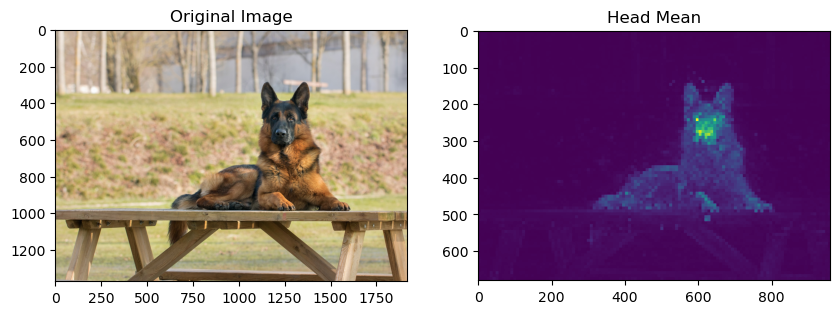

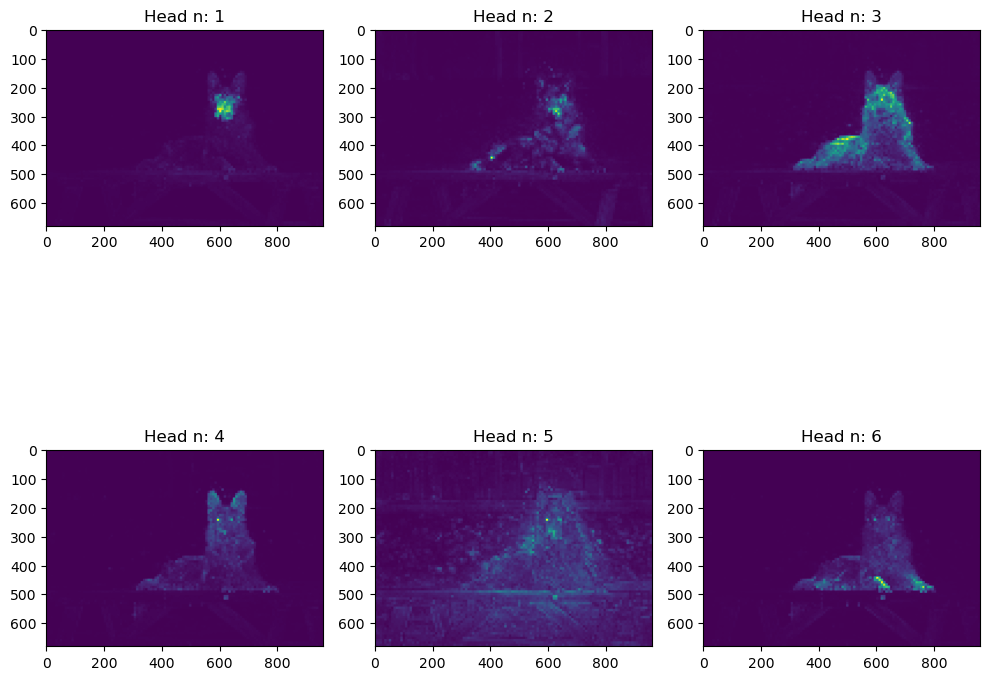

In [8]:
n_heads = attentions.shape[0]

plt.figure(figsize=(10, 10))
text = ["Original Image", "Head Mean"]
for i, fig in enumerate([img, np.mean(attentions, 0)]):
    plt.subplot(1, 2, i+1)
    plt.imshow(fig)
    plt.title(text[i])
plt.show()

plt.figure(figsize=(10, 10))
for i in range(n_heads):
    plt.subplot(n_heads//3, 3, i+1)
    plt.imshow(attentions[i])
    plt.title(f"Head n: {i+1}")
plt.tight_layout()
plt.show()

## Another Example

Lets try to extract the attention maps of the Iguana image.

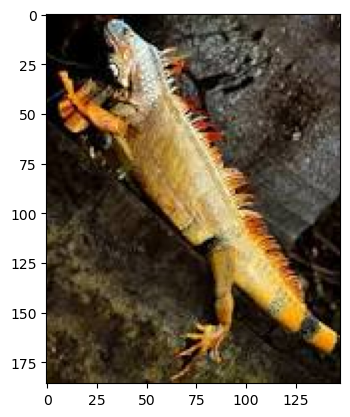

Image size:  (186, 148, 3)


In [9]:
path_to_img = '../data_and_models/images/Iguana.jpeg'
img = utils.read_img(path_to_img)
plt.imshow(img)
plt.show()

print("Image size: ", img.shape)

Our Iguana Image is not really big. So we resize it to larger size to have a better attention map.

In [10]:
img_size = (512, 512)
img_pre = utils.transform_img(img, mean, std, img_size=img_size)
print('Transformed image size: ', img_pre.size())

Transformed image size:  torch.Size([1, 3, 512, 512])


We load the model

In [11]:
name_model = 'vit_small'
patch_size = 8

model = VitGenerator(name_model, patch_size, 
                     device, evaluate=True, random=False, verbose=True)


[INFO] Initializing vit_small with patch size of 8
[INFO] Loading weights


Here we upscale the attentiion map to the original image size by specifying by specifying the size argument in nn.functional.interpolat()

In [12]:
# make the image divisible by the patch size
w, h = img_pre.shape[2] - img_pre.shape[2] % patch_size, img_pre.shape[3] - \
    img_pre.shape[3] % patch_size

img_pre = img_pre[:, :, :w, :h]
w_featmap = img_pre.shape[-2] // patch_size
h_featmap = img_pre.shape[-1] // patch_size

attentions = model.get_last_selfattention(img_pre.to(device))

nh = attentions.shape[1]  # number of head

# keep only the output patch attention
attentions = attentions[0, :, 0, 1:].reshape(nh, -1)
attentions = attentions.reshape(nh, w_featmap, h_featmap)
attentions = nn.functional.interpolate(attentions.unsqueeze(
    0), size=img_size, mode="nearest")[0].cpu().numpy()


Plot the attention maps

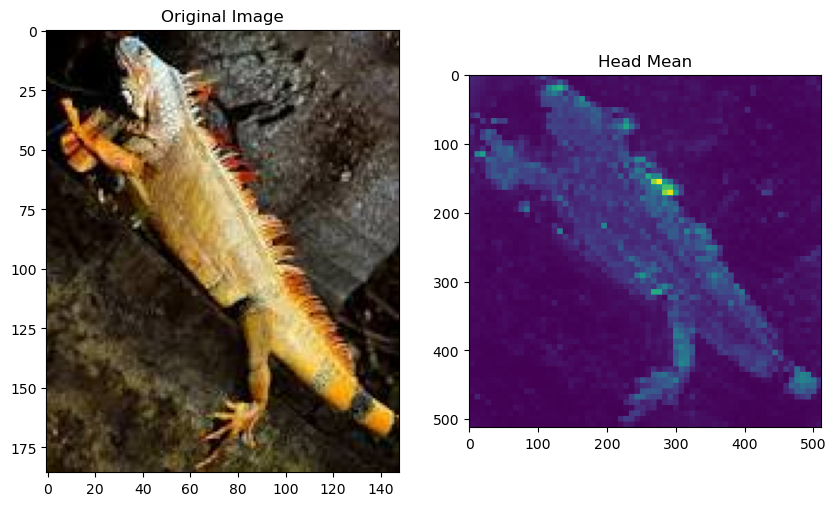

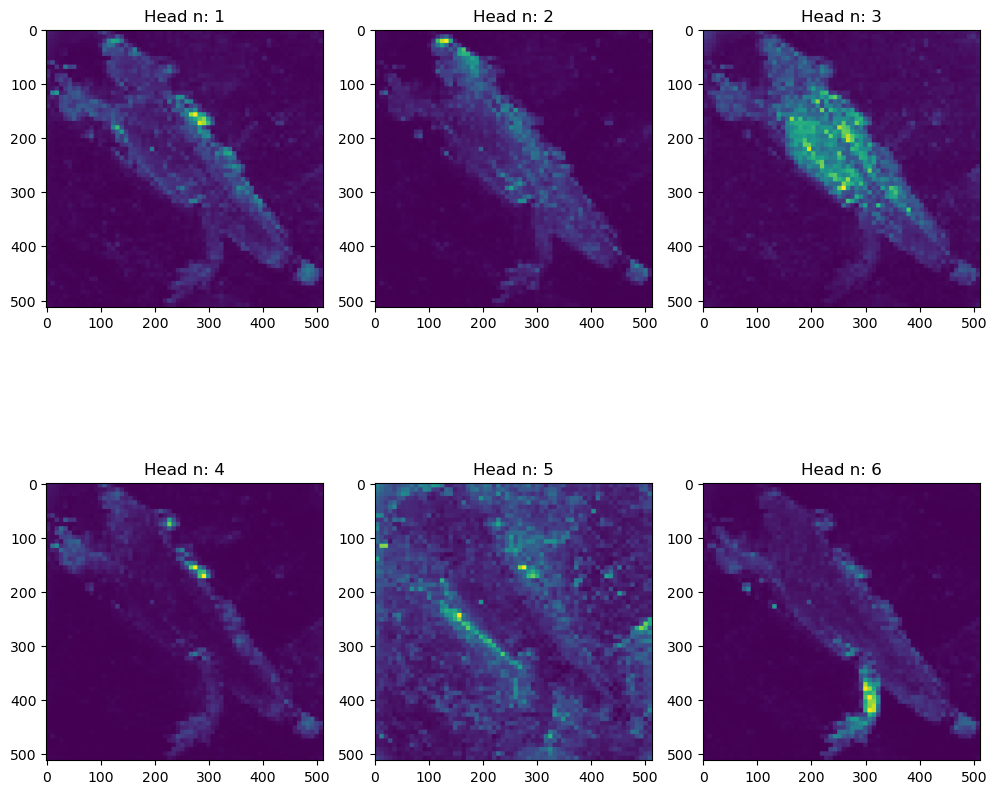

In [13]:
n_heads = attentions.shape[0]

plt.figure(figsize=(10, 10))
text = ["Original Image", "Head Mean"]
for i, fig in enumerate([img, np.mean(attentions, 0)]):
    plt.subplot(1, 2, i+1)
    plt.imshow(fig)
    plt.title(text[i])
plt.show()

plt.figure(figsize=(10, 10))
for i in range(n_heads):
    plt.subplot(n_heads//3, 3, i+1)
    plt.imshow(attentions[i])
    plt.title(f"Head n: {i+1}")
plt.tight_layout()
plt.show()